## ***Import the necessary libraries***

In [20]:
# import the libraries as shown below

from tensorflow.keras.layers import Input, Lambda, Dense, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.applications.resnet50 import ResNet50
#from keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator,load_img
from tensorflow.keras.models import Sequential
import numpy as np
from glob import glob
import matplotlib.pyplot as plt

## ***Resize***

* The code below sets IMAGE_SIZE variable is set to [224, 224], indicating the desired size for resizing the images. This means that all images will be resized to a shape of 224x224 pixels.


* The code snippet you provided defines these variables as paths to the directories where the training and validation images are stored. These paths will be used later when loading and processing the image data for training and evaluation.

In [21]:
# re-size all the images to this
IMAGE_SIZE = [224, 224]

train_path = '/content/drive/MyDrive/Datasets/Train'
valid_path = '/content/drive/MyDrive/Datasets/Test'

* A ResNet50 model is instantiated using the Keras ResNet50 function

* By instantiating the ResNet50 model with these parameters, you create a model that is pre-trained on ImageNet and has a convolutional base that can be used as a feature extractor. This base can then be combined with additional layers to build a custom classification model or perform other tasks.

In [22]:
# Import the Vgg 16 library as shown below and add preprocessing layer to the front of VGG
# Here we will be using imagenet weights

resnet = ResNet50(input_shape=IMAGE_SIZE + [3], weights='imagenet', include_top=False)

## ***don't train existing weights***

* Demonstrates how to freeze (make non-trainable) all the layers in the ResNet50 model. Additionally, it retrieves the number of output classes based on the subdirectories present in the training dataset.

In [34]:
# don't train existing weights
for layer in resnet.layers:
    layer.trainable = False


# useful for getting number of output classes
folders = glob('/content/drive/MyDrive/Datasets/Train/*')

## ***Defining Layers***

* A new dense layer with an activation function of softmax is added to the output of the ResNet50 model. This additional layer serves as the final prediction layer for the model.

* Next, a new Model object is created by specifying the inputs as the input layer of the ResNet50 model and the outputs as the prediction layer. This allows for the creation of a model that takes the pre-trained ResNet50 model as its base and adds the custom prediction layer on top.

* To inspect the structure of the model, the summary() method is called on the model object, which provides a summary of the model's architecture, including the number of parameters in each layer.

* In short, this adds a prediction layer to the ResNet50 model, creates a new model object by specifying the inputs and outputs, and then displays the summary of the model's structure using the model.summary() method. This enables a quick overview of the model's architecture and parameter counts.

In [35]:
# our layers - you can add more if you want
x = Flatten()(resnet.output)

In [36]:
prediction = Dense(len(folders), activation='softmax')(x)

# create a model object
model = Model(inputs=resnet.input, outputs=prediction)
# view the structure of the model
model.summary()


Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_3[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                            

## ***Defining Optimizers***

* The loss function is set to 'categorical_crossentropy', which is commonly used for multi-class classification problems. 

* The optimizer is set to 'adam', which is an efficient optimization algorithm commonly used in deep learning. Finally, the metric is set to ['accuracy'], indicating that the model's accuracy will be monitored during training.

In [37]:
# tell the model what cost and optimization method to use
model.compile(
  loss='categorical_crossentropy',
  optimizer='adam',
  metrics=['accuracy']
)

## ***Image Data Generator to import the images from the dataset***

* **train_datagen** is an instance of ImageDataGenerator that performs various data augmentation techniques on the training dataset. It rescales the pixel values to the range of 0 to 1, applies shear transformations, zoom transformations, and horizontal flipping.

* **test_datagen** is another instance of ImageDataGenerator that is used for the testing dataset. It simply rescales the pixel values to the range of 0 to 1.

* These **ImageDataGenerator** objects are used to preprocess and augment the image data, enhancing the model's ability to generalize and improving its performance during training and evaluation.

In [38]:
# Use the Image Data Generator to import the images from the dataset
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rescale = 1./255,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True)

test_datagen = ImageDataGenerator(rescale = 1./255)

In [39]:
# Make sure you provide the same target size as initialied for the image size
training_set = train_datagen.flow_from_directory('/content/drive/MyDrive/Datasets/Train',
                                                 target_size = (224, 224),
                                                 batch_size = 32,
                                                 class_mode = 'categorical')

Found 64 images belonging to 3 classes.


In [40]:
test_set = test_datagen.flow_from_directory('/content/drive/MyDrive/Datasets/Test',
                                            target_size = (224, 224),
                                            batch_size = 32,
                                            class_mode = 'categorical')

Found 58 images belonging to 3 classes.


* In the code below, model.fit_generator() is called to train the model. The training_set and test_set are provided as the training and validation data respectively. 

* The epochs parameter is set to 50, indicating the number of times the model will iterate over the entire training dataset. The steps_per_epoch parameter is set to len(training_set), which represents the number of batches to be processed in one epoch. 

* The validation_steps parameter is set to len(test_set), representing the number of batches to be processed for validation.



In [41]:
# fit the model
# Run the cell. It will take some time to execute
r = model.fit_generator(
  training_set,
  validation_data=test_set,
  epochs=50,
  steps_per_epoch=len(training_set),
  validation_steps=len(test_set)
)

<ipython-input-41-69229fe26ea3>:3: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  r = model.fit_generator(


Epoch 1/50
2/2 [==============================] - 32s 27s/step - loss: 7.9217 - accuracy: 0.3438 - val_loss: 5.9726 - val_accuracy: 0.3276
Epoch 2/50
2/2 [==============================] - 1s 788ms/step - loss: 5.7704 - accuracy: 0.3281 - val_loss: 7.7077 - val_accuracy: 0.1552
Epoch 3/50
2/2 [==============================] - 2s 1s/step - loss: 7.8773 - accuracy: 0.3125 - val_loss: 5.2780 - val_accuracy: 0.5172
Epoch 4/50
2/2 [==============================] - 2s 1s/step - loss: 5.1023 - accuracy: 0.3750 - val_loss: 1.7908 - val_accuracy: 0.5172
Epoch 5/50
2/2 [==============================] - 1s 781ms/step - loss: 1.7307 - accuracy: 0.4531 - val_loss: 5.5907 - val_accuracy: 0.3276
Epoch 6/50
2/2 [==============================] - 1s 816ms/step - loss: 3.4373 - accuracy: 0.4375 - val_loss: 5.5116 - val_accuracy: 0.2241
Epoch 7/50
2/2 [==============================] - 1s 825ms/step - loss: 3.1637 - accuracy: 0.4375 - val_loss: 2.5729 - val_accuracy: 0.2586
Epoch 8/50
2/2 [===========

## ***Plotting the loss***

* The loss plot by using the plot() function from matplotlib.pyplot. It plots the training loss (r.history['loss']) and validation loss (r.history['val_loss']) on the same graph. The label parameter is used to provide a label for each line. The legend() function is called to display the legend, and plt.show() is used to show the plot.

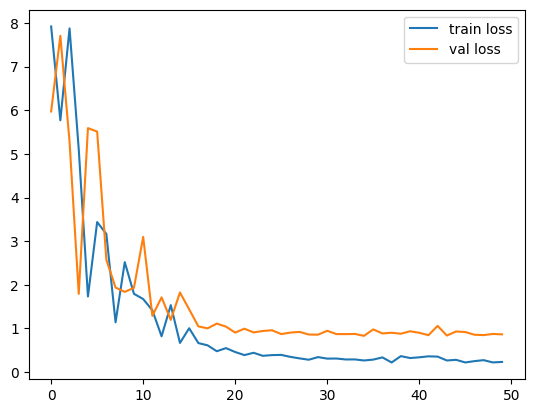

<Figure size 640x480 with 0 Axes>

In [44]:
# plot the loss
plt.plot(r.history['loss'], label='train loss')
plt.plot(r.history['val_loss'], label='val loss')
plt.legend()
plt.show()
plt.savefig('LossVal_loss')


## ***Plotting the Accuracy***

The accuracy plot by using the plot() function from matplotlib.pyplot. It plots the training accuracy (r.history['accuracy']) and validation accuracy (r.history['val_accuracy']) on the same graph. The label parameter is used to provide a label for each line. The legend() function is called to display the legend, and plt.show() is used to show the plot.

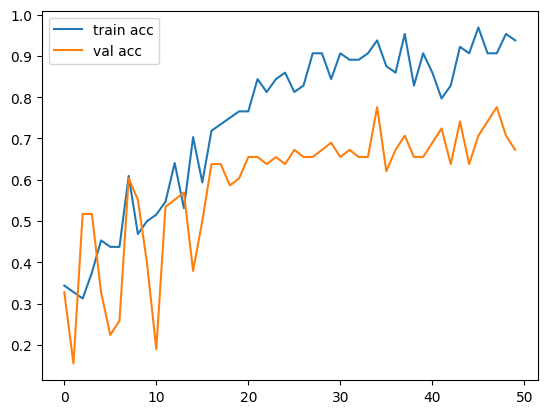

<Figure size 640x480 with 0 Axes>

In [45]:
# plot the accuracy
plt.plot(r.history['accuracy'], label='train acc')
plt.plot(r.history['val_accuracy'], label='val acc')
plt.legend()
plt.show()
plt.savefig('AccVal_acc')